<a href="https://colab.research.google.com/github/fralfaro/r4ds-book/blob/main/docs/28_graphics_for_communication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graphics for communication 

## Introduction

In \[exploratory data analysis\], you learned how to use plots as tools for *exploration*.
When you make exploratory plots, you know---even before looking---which variables the plot will display.
You made each plot for a purpose, could quickly look at it, and then move on to the next plot.
In the course of most analyses, you'll produce tens or hundreds of plots, most of which are immediately thrown away.


Now that you understand your data, you need to *communicate* your understanding to others.
Your audience will likely not share your background knowledge and will not be deeply invested in the data.
To help others quickly build up a good mental model of the data, you will need to invest considerable effort in making your plots as self-explanatory as possible.
In this chapter, you'll learn some of the tools that ggplot2 provides to do so.

This chapter focuses on the tools you need to create good graphics.
I assume that you know what you want, and just need to know how to do it.
For that reason, I highly recommend pairing this chapter with a good general visualisation book.
I particularly like [*The Truthful Art*](https://www.amazon.com/gp/product/0321934075/), by Albert Cairo.
It doesn't teach the mechanics of creating visualisations, but instead focuses on what you need to think about in order to create effective graphics.

### Prerequisites

In this chapter, we'll focus once again on ggplot2.
We'll also use a little dplyr for data manipulation, and a few ggplot2 extension packages, including **ggrepel** and **viridis**.
Rather than loading those extensions here, we'll refer to their functions explicitly, using the `::` notation.
This will help make it clear which functions are built into ggplot2, and which come from other packages.
Don't forget you'll need to install those packages with `install.packages()` if you don't already have them.



In [1]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




## Label

The easiest place to start when turning an exploratory graphic into an expository graphic is with good labels.
You add labels with the `labs()` function.
This example adds a plot title:



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



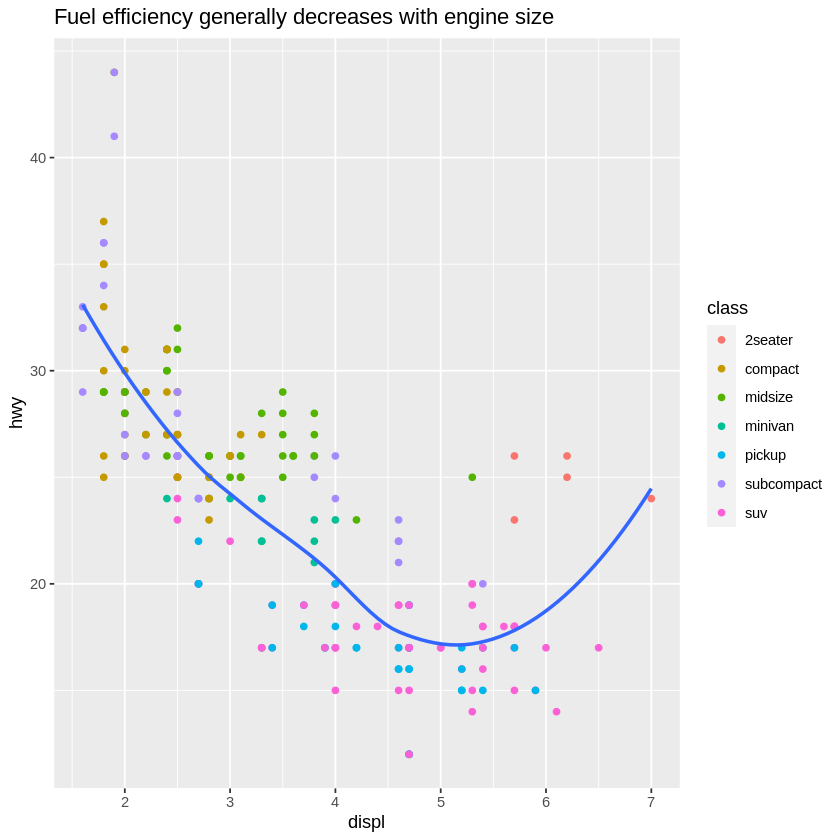

In [2]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = class)) +
  geom_smooth(se = FALSE) +
  labs(title = "Fuel efficiency generally decreases with engine size")


The purpose of a plot title is to summarise the main finding.
Avoid titles that just describe what the plot is, e.g. "A scatterplot of engine displacement vs. fuel economy".

If you need to add more text, there are two other useful labels that you can use in ggplot2 2.2.0 and above:

-   `subtitle` adds additional detail in a smaller font beneath the title.

-   `caption` adds text at the bottom right of the plot, often used to describe the source of the data.



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



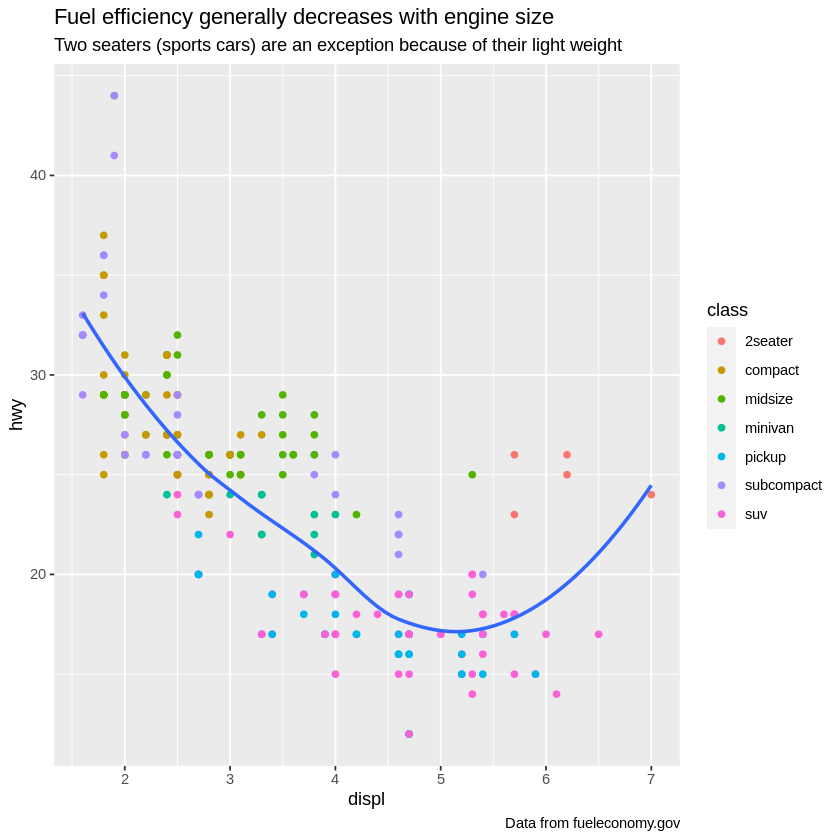

In [3]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = class)) +
  geom_smooth(se = FALSE) +
  labs(
    title = "Fuel efficiency generally decreases with engine size",
    subtitle = "Two seaters (sports cars) are an exception because of their light weight",
    caption = "Data from fueleconomy.gov"
  )


You can also use `labs()` to replace the axis and legend titles.
It's usually a good idea to replace short variable names with more detailed descriptions, and to include the units.



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



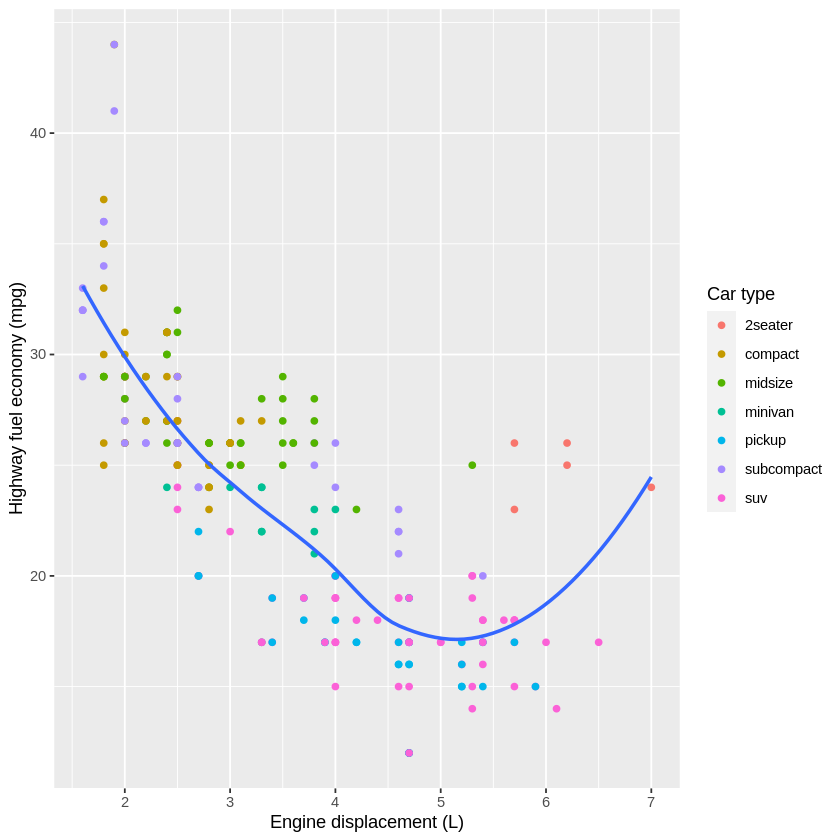

In [4]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  geom_smooth(se = FALSE) +
  labs(
    x = "Engine displacement (L)",
    y = "Highway fuel economy (mpg)",
    colour = "Car type"
  )


It's possible to use mathematical equations instead of text strings.
Just switch `""` out for `quote()` and read about the available options in `?plotmath`:



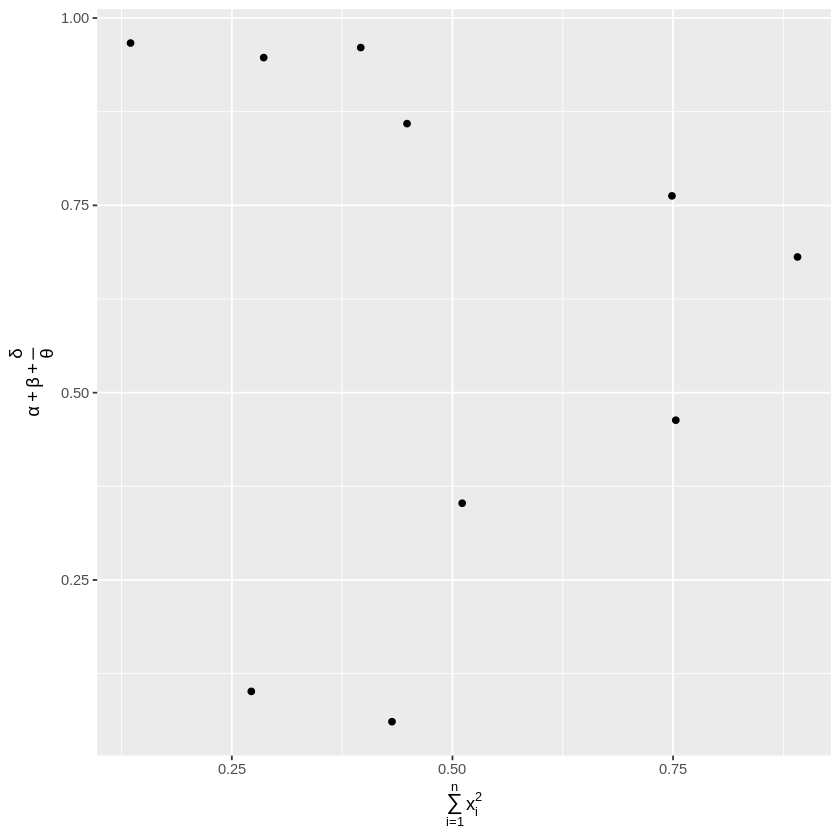

In [5]:
df <- tibble(
  x = runif(10),
  y = runif(10)
)
ggplot(df, aes(x, y)) +
  geom_point() +
  labs(
    x = quote(sum(x[i] ^ 2, i == 1, n)),
    y = quote(alpha + beta + frac(delta, theta))
  )


### Exercises

1.  Create one plot on the fuel economy data with customised `title`, `subtitle`, `caption`, `x`, `y`, and `colour` labels.

2.  The `geom_smooth()` is somewhat misleading because the `hwy` for large engines is skewed upwards due to the inclusion of lightweight sports cars with big engines.
    Use your modelling tools to fit and display a better model.
    <!--# TO DO: Reconsider this exercise in light of removing modeling chapters. -->

3.  Take an exploratory graphic that you've created in the last month, and add informative titles to make it easier for others to understand.

## Annotations

In addition to labelling major components of your plot, it's often useful to label individual observations or groups of observations.
The first tool you have at your disposal is `geom_text()`.
`geom_text()` is similar to `geom_point()`, but it has an additional aesthetic: `label`.
This makes it possible to add textual labels to your plots.

There are two possible sources of labels.
First, you might have a tibble that provides labels.
The plot below isn't terribly useful, but it illustrates a useful approach: pull out the most efficient car in each class with dplyr, and then label it on the plot:


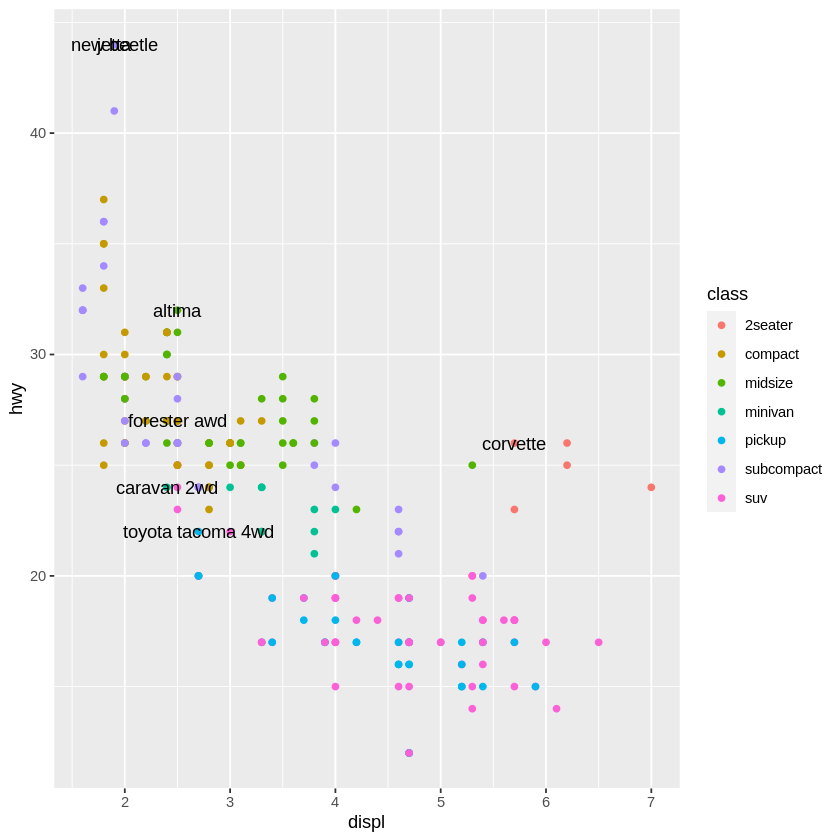

In [6]:
best_in_class <- mpg |>
  group_by(class) |>
  filter(row_number(desc(hwy)) == 1)

ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  geom_text(aes(label = model), data = best_in_class)


This is hard to read because the labels overlap with each other, and with the points.
We can make things a little better by switching to `geom_label()` which draws a rectangle behind the text.
We also use the `nudge_y` parameter to move the labels slightly above the corresponding points:



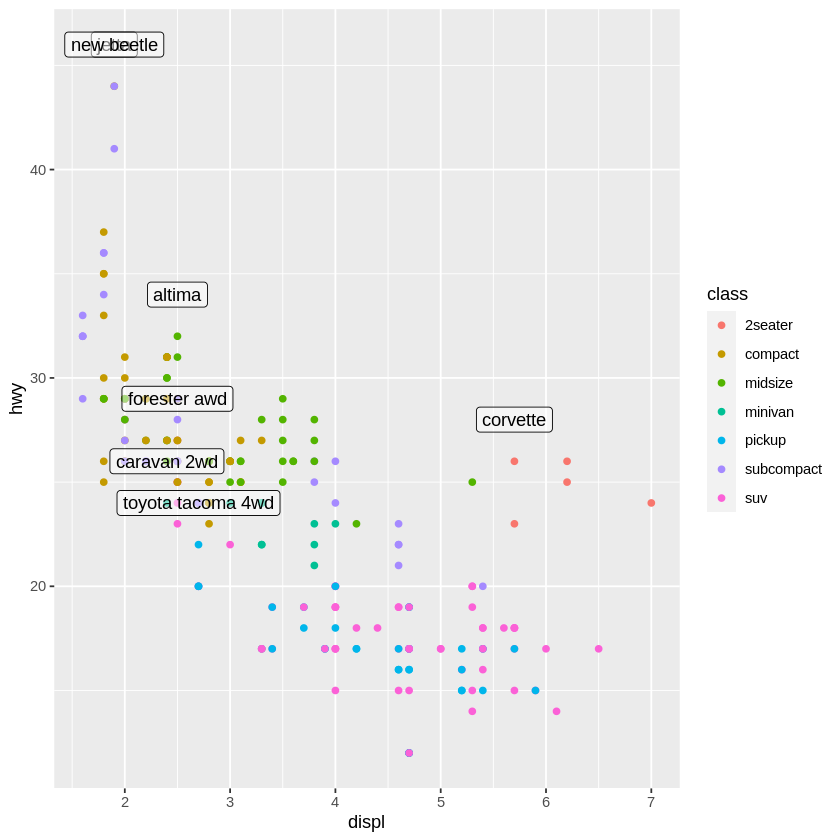

In [7]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  geom_label(aes(label = model), data = best_in_class, nudge_y = 2, alpha = 0.5)


That helps a bit, but if you look closely in the top-left hand corner, you'll notice that there are two labels practically on top of each other.
This happens because the highway mileage and displacement for the best cars in the compact and subcompact categories are exactly the same.
There's no way that we can fix these by applying the same transformation for every label.
Instead, we can use the **ggrepel** package by Kamil Slowikowski.
This useful package will automatically adjust labels so that they don't overlap:



In [9]:
install.packages("ggrepel")
library(ggrepel)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’




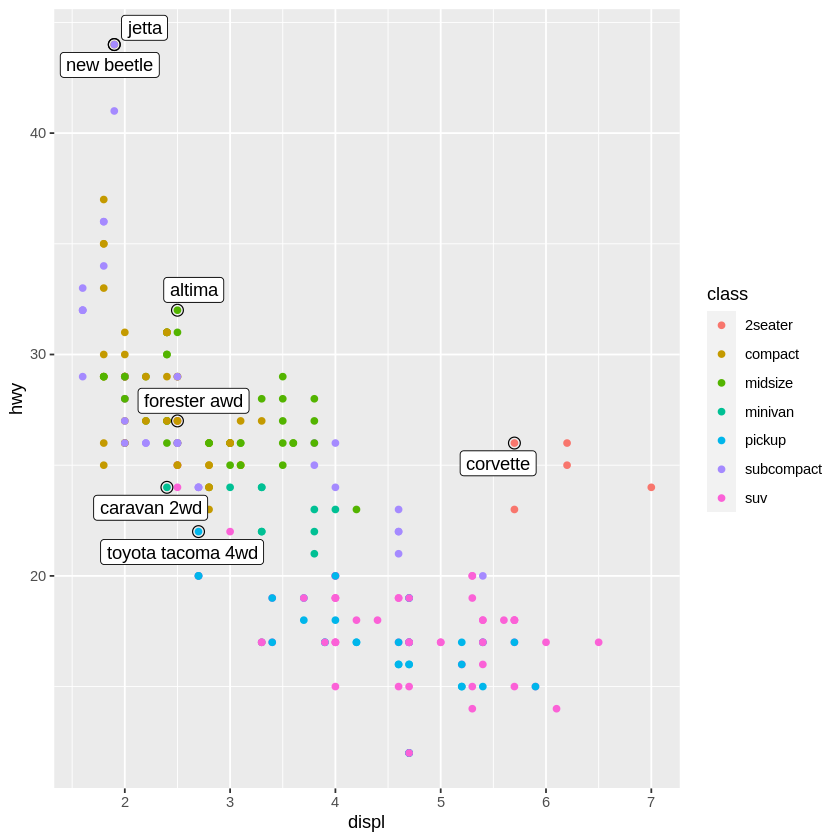

In [10]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  geom_point(size = 3, shape = 1, data = best_in_class) +
  ggrepel::geom_label_repel(aes(label = model), data = best_in_class)


Note another handy technique used here: I added a second layer of large, hollow points to highlight the points that I've labelled.

You can sometimes use the same idea to replace the legend with labels placed directly on the plot.
It's not wonderful for this plot, but it isn't too bad.
(`theme(legend.position = "none"`) turns the legend off --- we'll talk about it more shortly.)



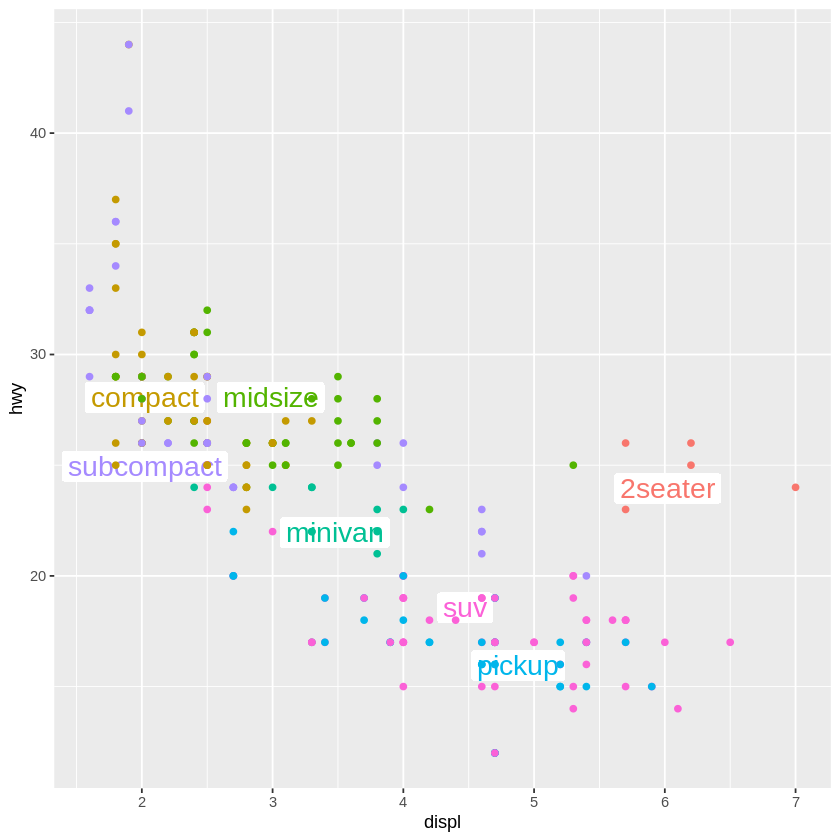

In [11]:
class_avg <- mpg |>
  group_by(class) |>
  summarise(
    displ = median(displ),
    hwy = median(hwy)
  )

ggplot(mpg, aes(displ, hwy, colour = class)) +
  ggrepel::geom_label_repel(aes(label = class),
    data = class_avg,
    size = 6,
    label.size = 0,
    segment.color = NA
  ) +
  geom_point() +
  theme(legend.position = "none")


Alternatively, you might just want to add a single label to the plot, but you'll still need to create a data frame.
Often, you want the label in the corner of the plot, so it's convenient to create a new data frame using `summarise()` to compute the maximum values of x and y.



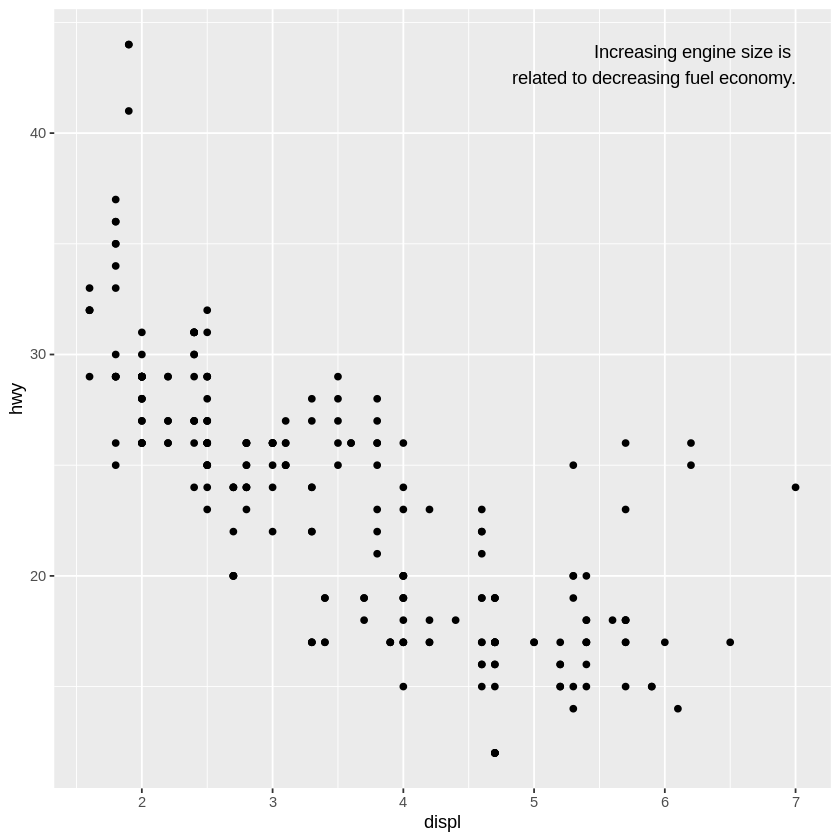

In [12]:
label <- mpg |>
  summarise(
    displ = max(displ),
    hwy = max(hwy),
    label = "Increasing engine size is \nrelated to decreasing fuel economy."
  )

ggplot(mpg, aes(displ, hwy)) +
  geom_point() +
  geom_text(aes(label = label), data = label, vjust = "top", hjust = "right")


If you want to place the text exactly on the borders of the plot, you can use `+Inf` and `-Inf`.
Since we're no longer computing the positions from `mpg`, we can use `tibble()` to create the data frame:



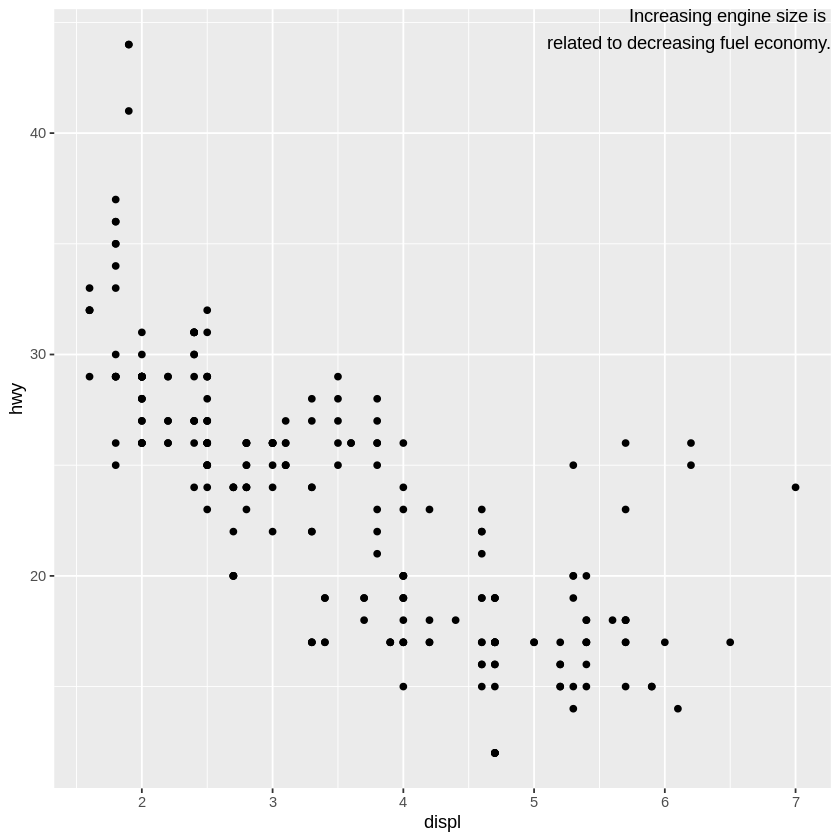

In [13]:
label <- tibble(
  displ = Inf,
  hwy = Inf,
  label = "Increasing engine size is \nrelated to decreasing fuel economy."
)

ggplot(mpg, aes(displ, hwy)) +
  geom_point() +
  geom_text(aes(label = label), data = label, vjust = "top", hjust = "right")


In these examples, I manually broke the label up into lines using `"\n"`.
Another approach is to use `stringr::str_wrap()` to automatically add line breaks, given the number of characters you want per line:



In [14]:
"Increasing engine size is related to decreasing fuel economy." |>
  stringr::str_wrap(width = 40) |>
  writeLines()

Increasing engine size is related to
decreasing fuel economy.



Note the use of `hjust` and `vjust` to control the alignment of the label.
@fig-just shows all nine possible combinations.



<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/9f9f1806b5c583874a725bdff526e990bd4fcba6/b955a/communicate-plots_files/figure-html/just-1.png" alt="img R" >
    All nine combinations of `hjust` and `vjust`.
</center>


Remember, in addition to `geom_text()`, you have many other geoms in ggplot2 available to help annotate your plot.
A few ideas:

-   Use `geom_hline()` and `geom_vline()` to add reference lines.
    I often make them thick (`size = 2`) and white (`colour = white`), and draw them underneath the primary data layer.
    That makes them easy to see, without drawing attention away from the data.

-   Use `geom_rect()` to draw a rectangle around points of interest.
    The boundaries of the rectangle are defined by aesthetics `xmin`, `xmax`, `ymin`, `ymax`.

-   Use `geom_segment()` with the `arrow` argument to draw attention to a point with an arrow.
    Use aesthetics `x` and `y` to define the starting location, and `xend` and `yend` to define the end location.

The only limit is your imagination (and your patience with positioning annotations to be aesthetically pleasing)!

### Exercises

1.  Use `geom_text()` with infinite positions to place text at the four corners of the plot.

2.  Read the documentation for `annotate()`.
    How can you use it to add a text label to a plot without having to create a tibble?

3.  How do labels with `geom_text()` interact with faceting?
    How can you add a label to a single facet?
    How can you put a different label in each facet?
    (Hint: think about the underlying data.)

4.  What arguments to `geom_label()` control the appearance of the background box?

5.  What are the four arguments to `arrow()`?
    How do they work?
    Create a series of plots that demonstrate the most important options.

## Scales

The third way you can make your plot better for communication is to adjust the scales.
Scales control the mapping from data values to things that you can perceive.
Normally, ggplot2 automatically adds scales for you.
For example, when you type:



```rggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class))
```



ggplot2 automatically adds default scales behind the scenes:

```rggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  scale_x_continuous() +
  scale_y_continuous() +
  scale_colour_discrete()
```



Note the naming scheme for scales: `scale_` followed by the name of the aesthetic, then `_`, then the name of the scale.
The default scales are named according to the type of variable they align with: continuous, discrete, datetime, or date.
There are lots of non-default scales which you'll learn about below.

The default scales have been carefully chosen to do a good job for a wide range of inputs.
Nevertheless, you might want to override the defaults for two reasons:

-   You might want to tweak some of the parameters of the default scale.
    This allows you to do things like change the breaks on the axes, or the key labels on the legend.

-   You might want to replace the scale altogether, and use a completely different algorithm.
    Often you can do better than the default because you know more about the data.

### Axis ticks and legend keys

There are two primary arguments that affect the appearance of the ticks on the axes and the keys on the legend: `breaks` and `labels`.
Breaks controls the position of the ticks, or the values associated with the keys.
Labels controls the text label associated with each tick/key.
The most common use of `breaks` is to override the default choice:


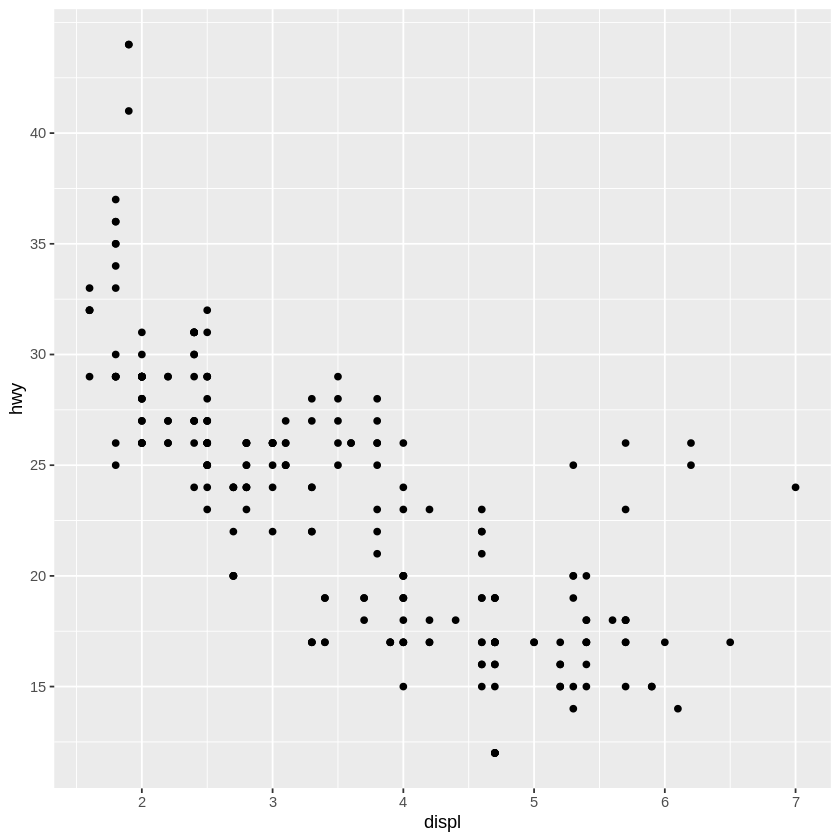

In [15]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point() +
  scale_y_continuous(breaks = seq(15, 40, by = 5))


You can use `labels` in the same way (a character vector the same length as `breaks`), but you can also set it to `NULL` to suppress the labels altogether.
This is useful for maps, or for publishing plots where you can't share the absolute numbers.



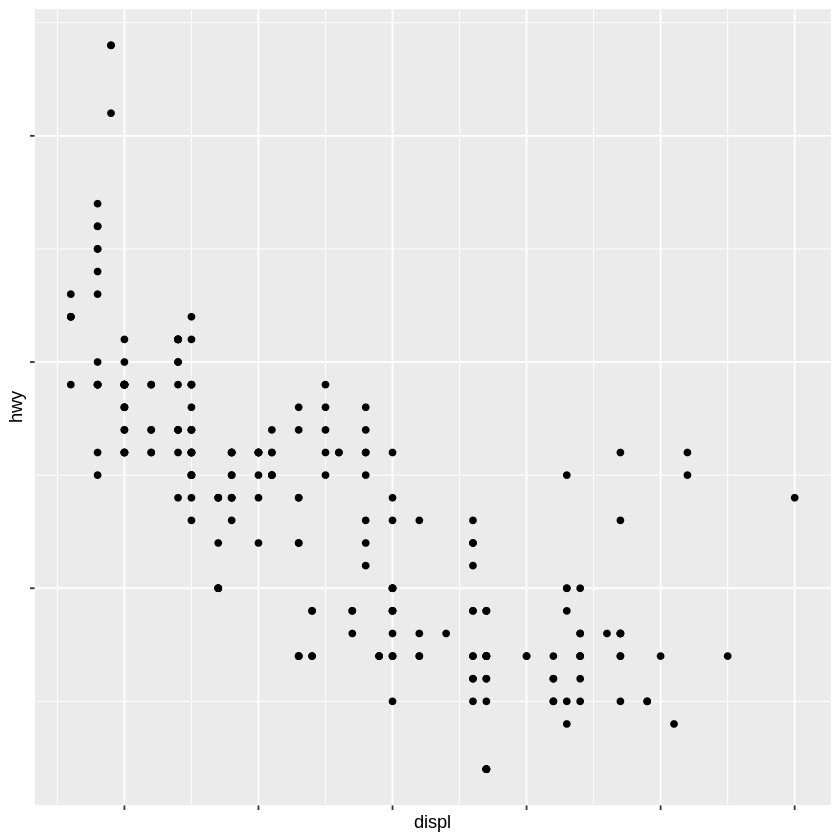

In [16]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point() +
  scale_x_continuous(labels = NULL) +
  scale_y_continuous(labels = NULL)


You can also use `breaks` and `labels` to control the appearance of legends.
Collectively axes and legends are called **guides**.
Axes are used for x and y aesthetics; legends are used for everything else.

Another use of `breaks` is when you have relatively few data points and want to highlight exactly where the observations occur.
For example, take this plot that shows when each US president started and ended their term.



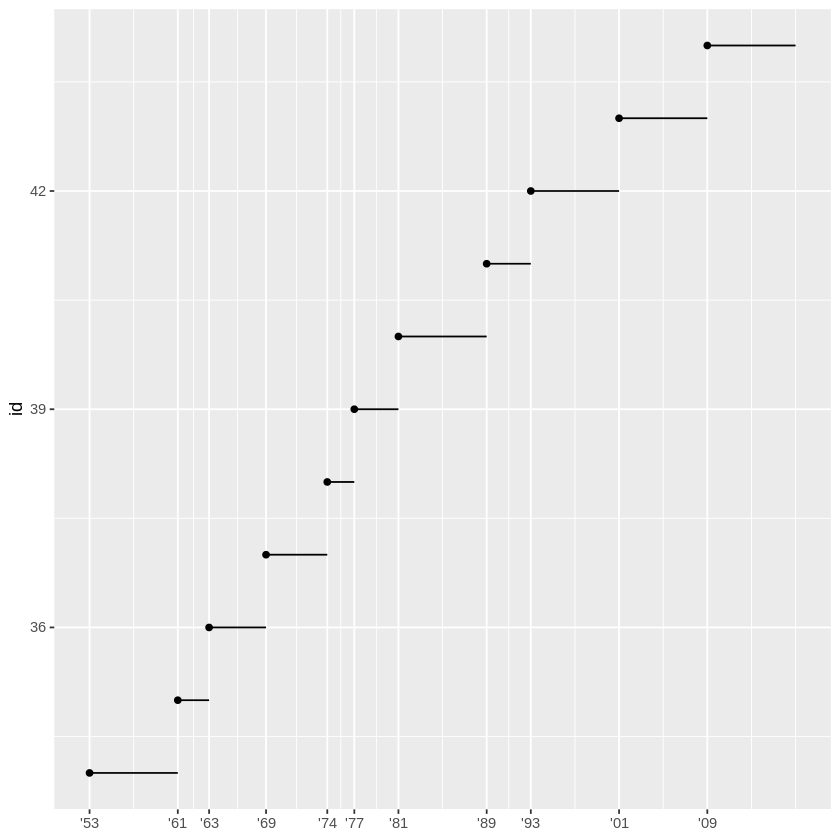

In [17]:
presidential |>
  mutate(id = 33 + row_number()) |>
  ggplot(aes(start, id)) +
    geom_point() +
    geom_segment(aes(xend = end, yend = id)) +
    scale_x_date(NULL, breaks = presidential$start, date_labels = "'%y")


Note that the specification of breaks and labels for date and datetime scales is a little different:

-   `date_labels` takes a format specification, in the same form as `parse_datetime()`.

-   `date_breaks` (not shown here), takes a string like "2 days" or "1 month".

### Legend layout

You will most often use `breaks` and `labels` to tweak the axes.
While they both also work for legends, there are a few other techniques you are more likely to use.

To control the overall position of the legend, you need to use a `theme()` setting.
We'll come back to themes at the end of the chapter, but in brief, they control the non-data parts of the plot.
The theme setting `legend.position` controls where the legend is drawn:



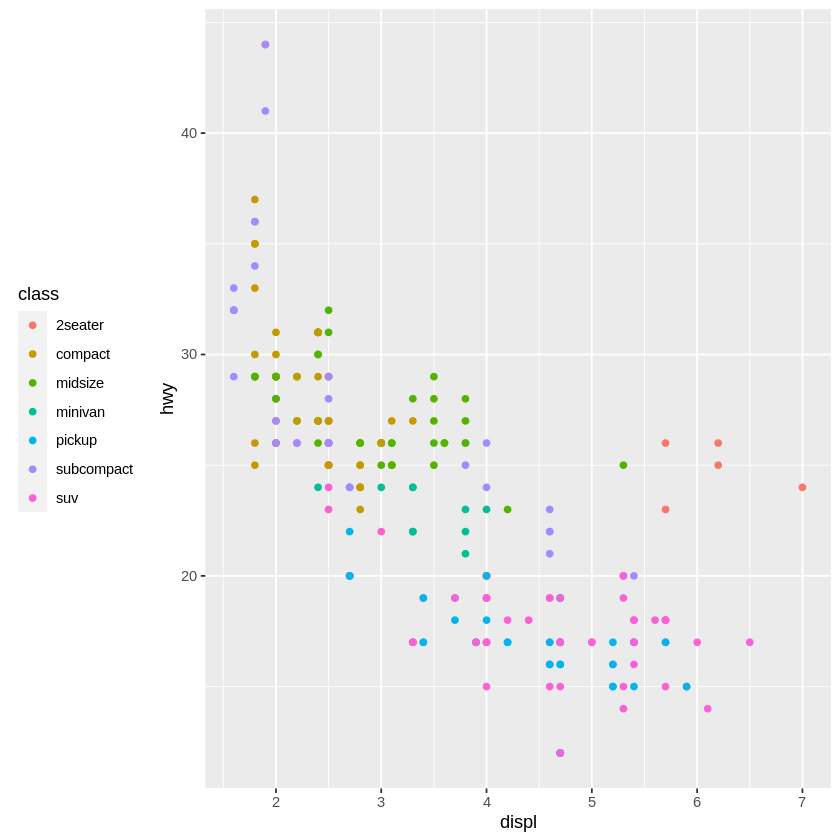

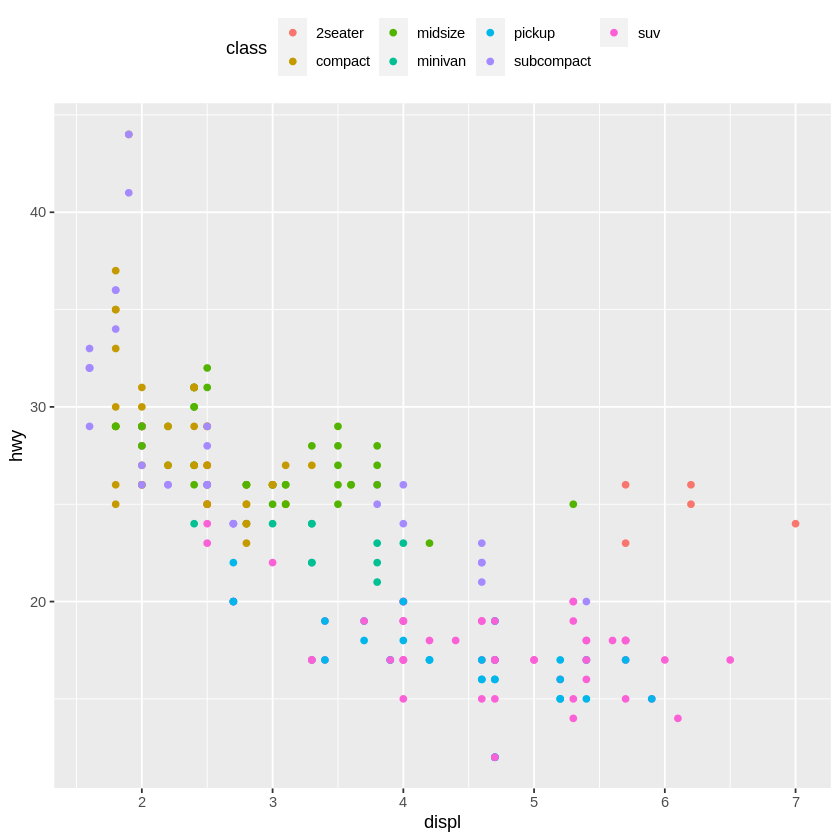

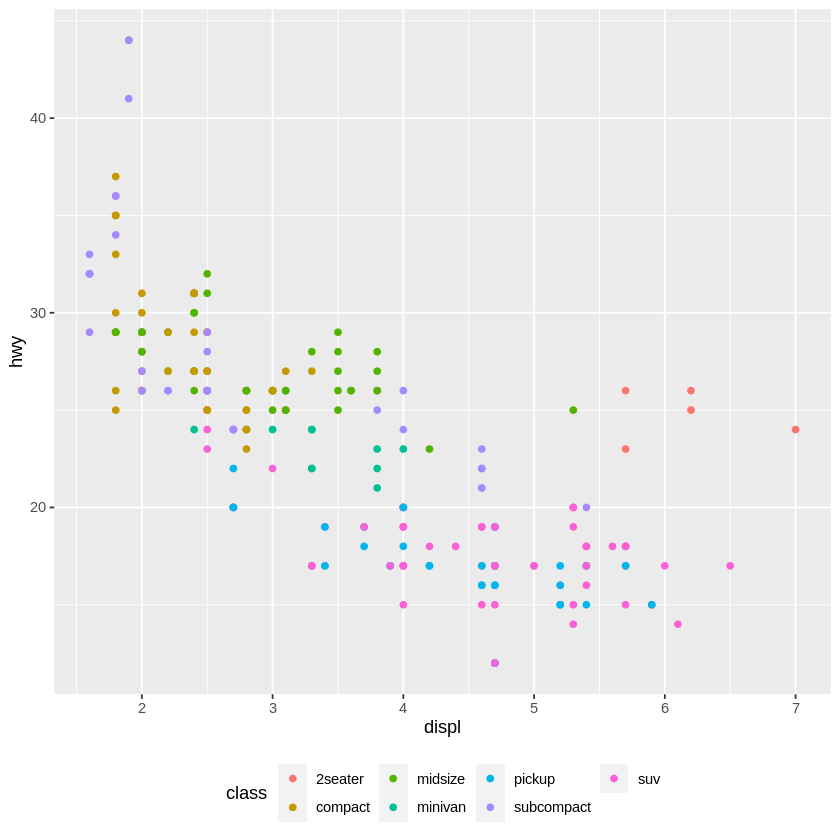

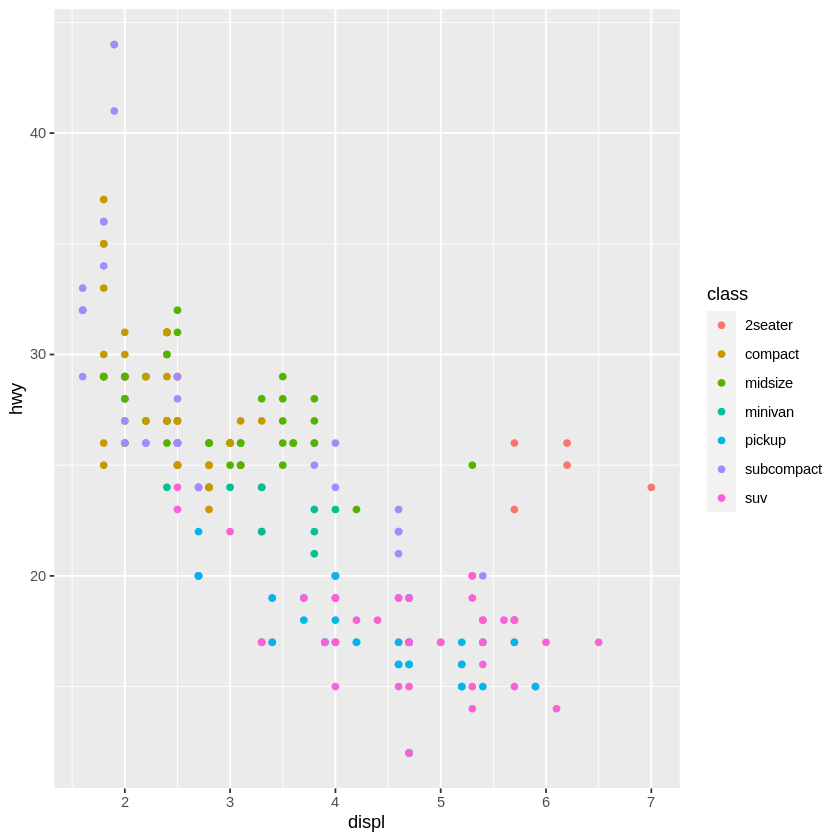

In [18]:
base <- ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class))

base + theme(legend.position = "left")
base + theme(legend.position = "top")
base + theme(legend.position = "bottom")
base + theme(legend.position = "right") # the default


You can also use `legend.position = "none"` to suppress the display of the legend altogether.

To control the display of individual legends, use `guides()` along with `guide_legend()` or `guide_colourbar()`.
The following example shows two important settings: controlling the number of rows the legend uses with `nrow`, and overriding one of the aesthetics to make the points bigger.
This is particularly useful if you have used a low `alpha` to display many points on a plot.



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



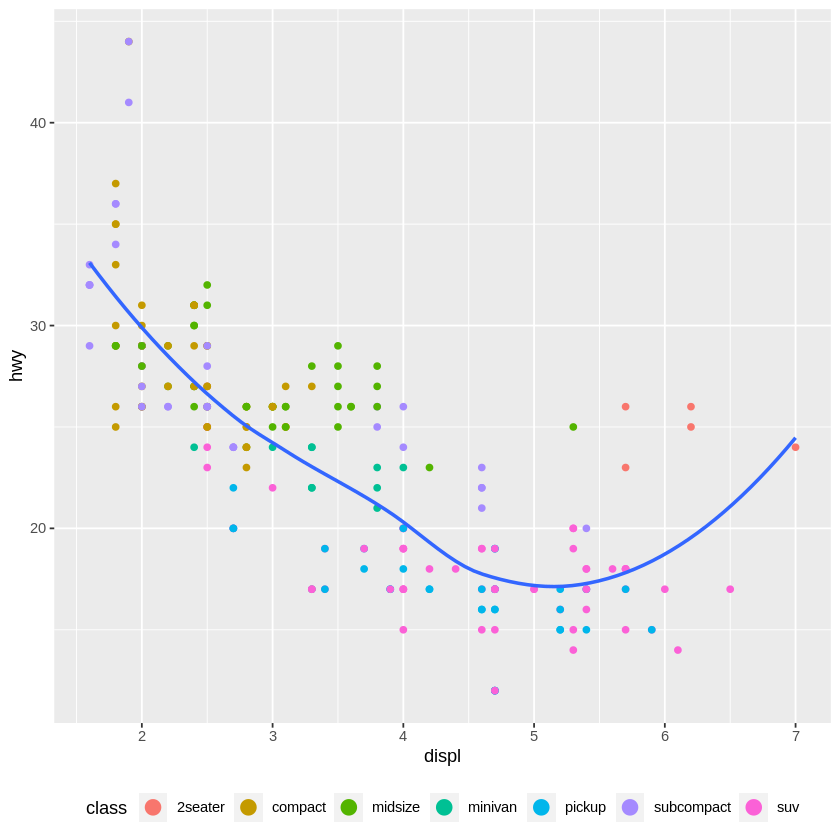

In [19]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(colour = class)) +
  geom_smooth(se = FALSE) +
  theme(legend.position = "bottom") +
  guides(colour = guide_legend(nrow = 1, override.aes = list(size = 4)))


### Replacing a scale

Instead of just tweaking the details a little, you can instead replace the scale altogether.
There are two types of scales you're mostly likely to want to switch out: continuous position scales and colour scales.
Fortunately, the same principles apply to all the other aesthetics, so once you've mastered position and colour, you'll be able to quickly pick up other scale replacements.

It's very useful to plot transformations of your variable.
For example, as we've seen in [diamond prices](diamond-prices) it's easier to see the precise relationship between `carat` and `price` if we log transform them:



```r
ggplot(diamonds, aes(carat, price)) +
  geom_bin2d()

ggplot(diamonds, aes(log10(carat), log10(price))) +
  geom_bin2d()
```

<img src="https://d33wubrfki0l68.cloudfront.net/8c68bf4fc2f73d30c612a5213359b077d81bba99/6b464/communicate-plots_files/figure-html/unnamed-chunk-19-1.png" alt="img R" 
     width="400" height="300"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/7277afd22a6305d7ddfdb84c3014fe757c651614/bc46b/communicate-plots_files/figure-html/unnamed-chunk-19-2.png" alt="img R" 
     width="400" height="300"  align="left" >


However, the disadvantage of this transformation is that the axes are now labelled with the transformed values, making it hard to interpret the plot.
Instead of doing the transformation in the aesthetic mapping, we can instead do it with the scale.
This is visually identical, except the axes are labelled on the original data scale.



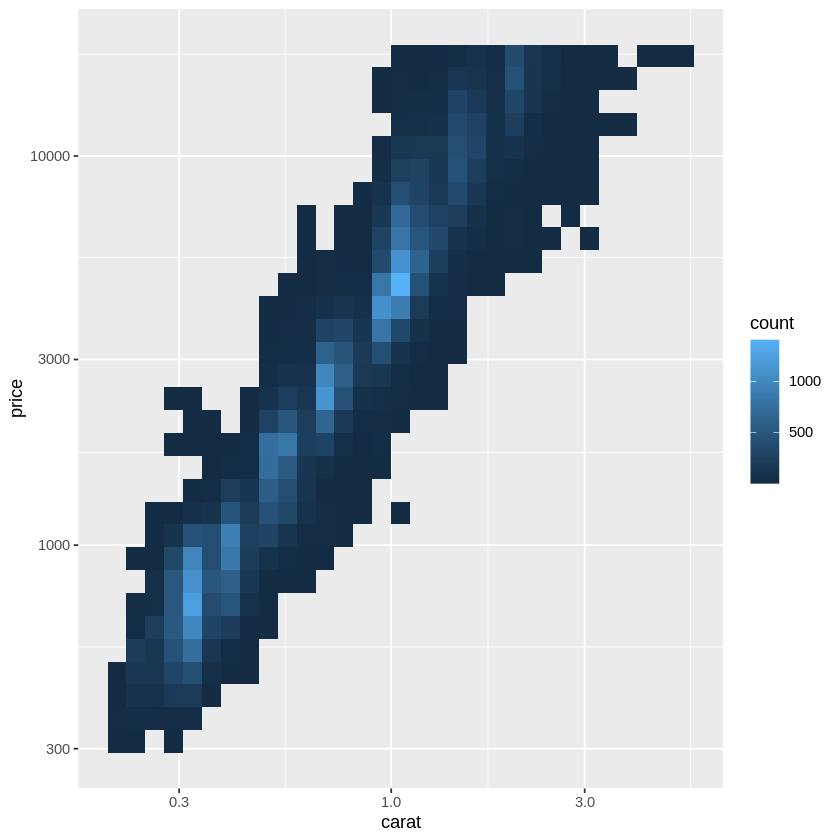

In [21]:
ggplot(diamonds, aes(carat, price)) +
  geom_bin2d() + 
  scale_x_log10() + 
  scale_y_log10()



Another scale that is frequently customised is colour.
The default categorical scale picks colours that are evenly spaced around the colour wheel.
Useful alternatives are the ColorBrewer scales which have been hand tuned to work better for people with common types of colour blindness.
The two plots below look similar, but there is enough difference in the shades of red and green that the dots on the right can be distinguished even by people with red-green colour blindness.



```r
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = drv))

ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = drv)) +
  scale_colour_brewer(palette = "Set1")
```


<img src="https://d33wubrfki0l68.cloudfront.net/5893aa79552bf15b4bfba426baadc0ada4405bdc/450ff/communicate-plots_files/figure-html/unnamed-chunk-21-1.png" alt="img R" 
     width="400" height="300"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/5afba36aee0c33e02a418bc453bffed134f71a0e/2fef8/communicate-plots_files/figure-html/unnamed-chunk-21-2.png" alt="img R" 
     width="400" height="300"  align="left" >


Don't forget simpler techniques.
If there are just a few colours, you can add a redundant shape mapping.
This will also help ensure your plot is interpretable in black and white.


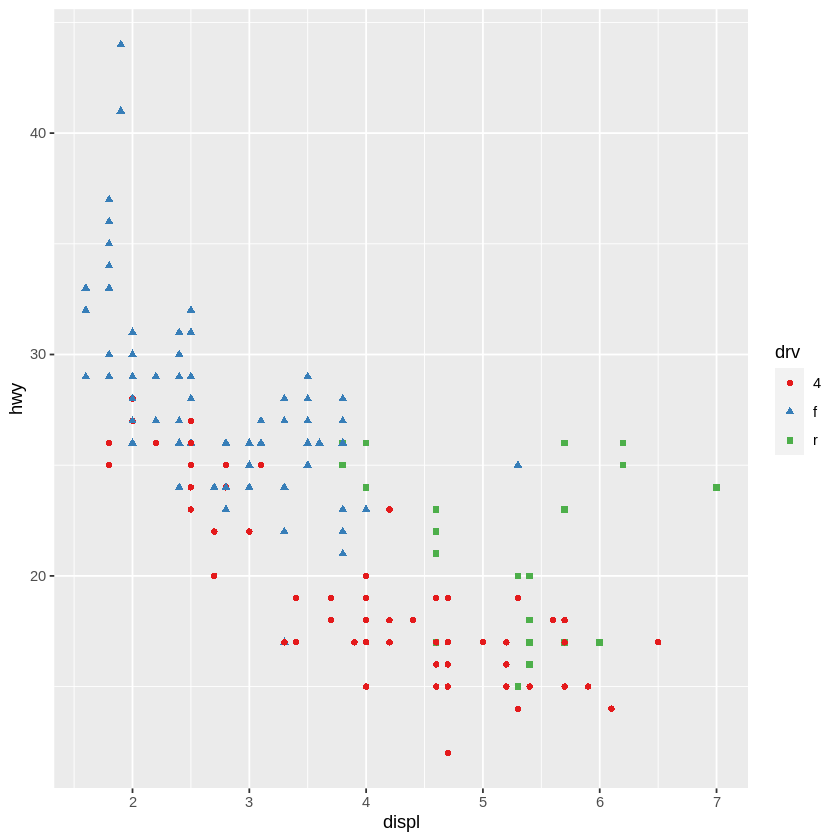

In [22]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = drv, shape = drv)) +
  scale_colour_brewer(palette = "Set1")


The ColorBrewer scales are documented online at <http://colorbrewer2.org/> and made available in R via the **RColorBrewer** package, by Erich Neuwirth.
@fig-brewer shows the complete list of all palettes.
The sequential (top) and diverging (bottom) palettes are particularly useful if your categorical values are ordered, or have a "middle".
This often arises if you've used `cut()` to make a continuous variable into a categorical variable.



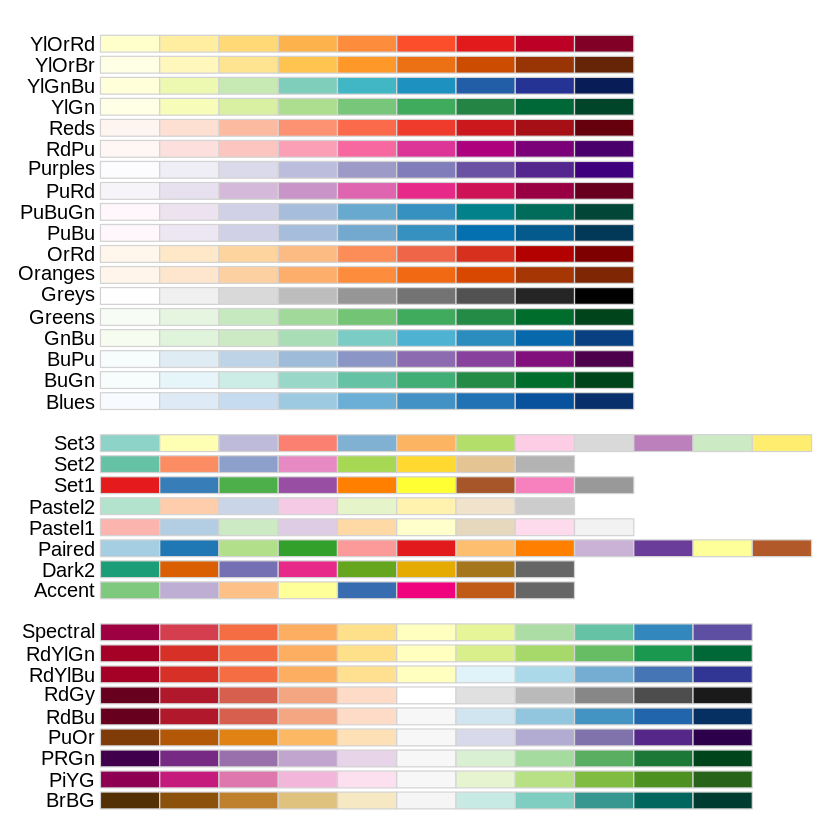

In [23]:
par(mar = c(0, 3, 0, 0))
RColorBrewer::display.brewer.all()


When you have a predefined mapping between values and colours, use `scale_colour_manual()`.
For example, if we map presidential party to colour, we want to use the standard mapping of red for Republicans and blue for Democrats:


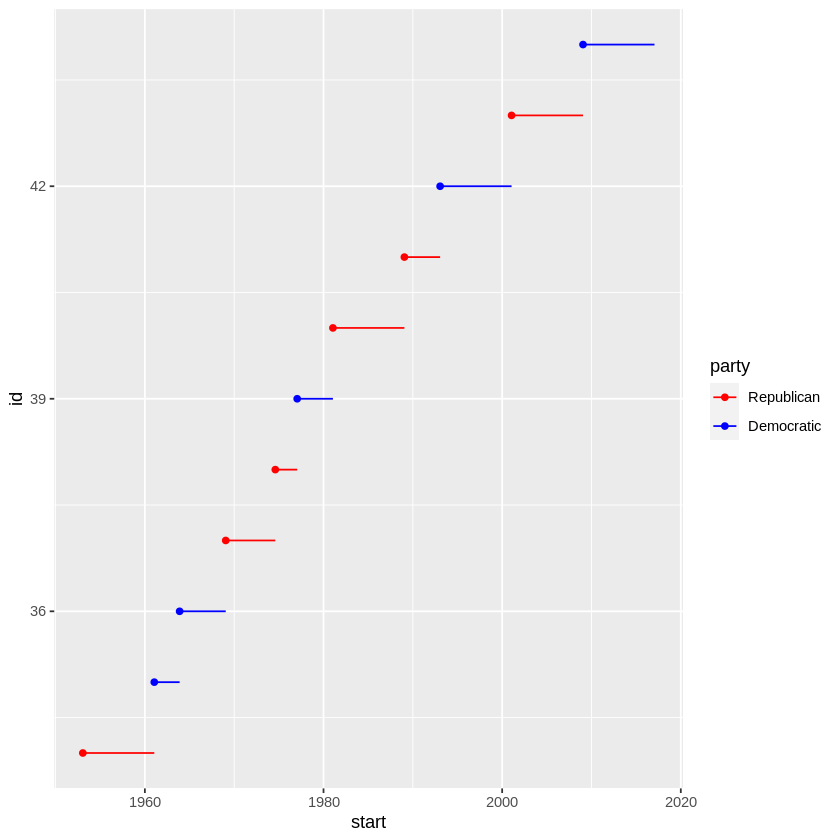

In [24]:
presidential |>
  mutate(id = 33 + row_number()) |>
  ggplot(aes(start, id, colour = party)) +
    geom_point() +
    geom_segment(aes(xend = end, yend = id)) +
    scale_colour_manual(values = c(Republican = "red", Democratic = "blue"))


For continuous colour, you can use the built-in `scale_colour_gradient()` or `scale_fill_gradient()`.
If you have a diverging scale, you can use `scale_colour_gradient2()`.
That allows you to give, for example, positive and negative values different colours.
That's sometimes also useful if you want to distinguish points above or below the mean.

Another option is `scale_colour_viridis()` provided by the **viridis** package.
It's a continuous analog of the categorical ColorBrewer scales.
The designers, Nathaniel Smith and Stéfan van der Walt, carefully tailored a continuous colour scheme that has good perceptual properties.
Here's an example from the viridis vignette.



```r
df <- tibble(
  x = rnorm(10000),
  y = rnorm(10000)
)
ggplot(df, aes(x, y)) +
  geom_hex() +
  coord_fixed()

ggplot(df, aes(x, y)) +
  geom_hex() +
  viridis::scale_fill_viridis() +
  coord_fixed()
```

<img src="https://d33wubrfki0l68.cloudfront.net/4c0d05d615b88e947fb5eaa1a5395ef941e4de4d/6ddf8/communicate-plots_files/figure-html/unnamed-chunk-24-1.png" alt="img R" 
     width="350" height="350"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/8cd60919f224004d159328b7b54038fe5c5de56a/96a36/communicate-plots_files/figure-html/unnamed-chunk-24-2.png" alt="img R" 
     width="350" height="350"  align="left" >


Note that all colour scales come in two variety: `scale_colour_x()` and `scale_fill_x()` for the `colour` and `fill` aesthetics respectively (the colour scales are available in both UK and US spellings).

### Exercises

1.  Why doesn't the following code override the default scale?

    ```r
    ggplot(df, aes(x, y)) +
      geom_hex() +
      scale_colour_gradient(low = "white", high = "red") +
      coord_fixed()
    ```



2.  What is the first argument to every scale?
    How does it compare to `labs()`?

3.  Change the display of the presidential terms by:

    a.  Combining the two variants shown above.
    b.  Improving the display of the y axis.
    c.  Labelling each term with the name of the president.
    d.  Adding informative plot labels.
    e.  Placing breaks every 4 years (this is trickier than it seems!).

4.  Use `override.aes` to make the legend on the following plot easier to see.


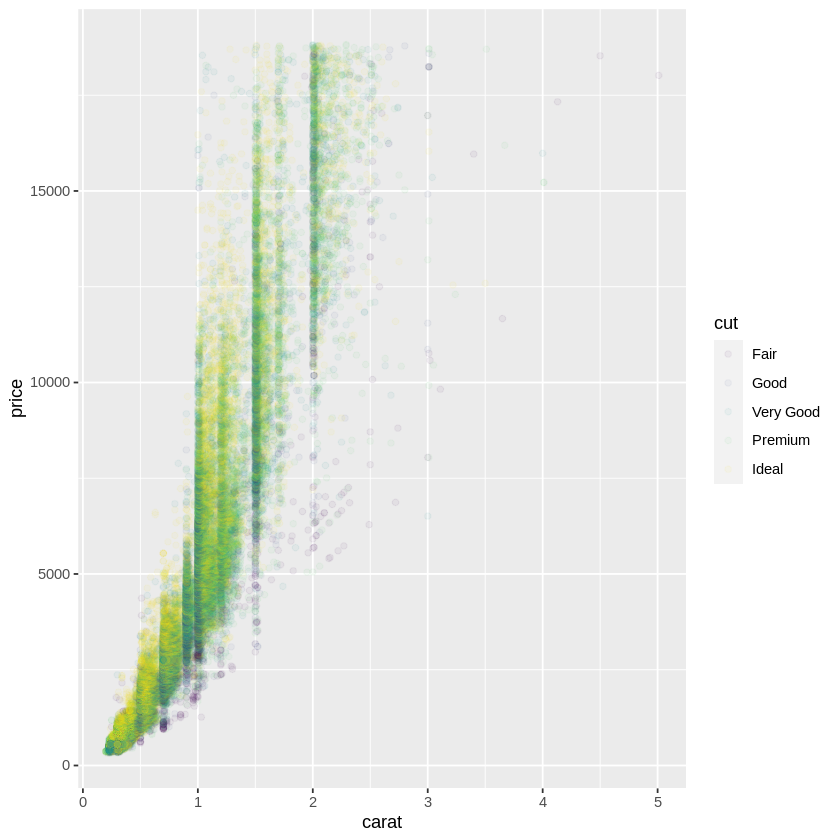

In [25]:
ggplot(diamonds, aes(carat, price)) +
  geom_point(aes(colour = cut), alpha = 1/20)


## Zooming

There are three ways to control the plot limits:

1.  Adjusting what data are plotted
2.  Setting the limits in each scale
3.  Setting `xlim` and `ylim` in `coord_cartesian()`

To zoom in on a region of the plot, it's generally best to use `coord_cartesian()`.
Compare the following two plots:




```r
ggplot(mpg, mapping = aes(displ, hwy)) +
  geom_point(aes(color = class)) +
  geom_smooth() +
  coord_cartesian(xlim = c(5, 7), ylim = c(10, 30))

mpg |>
  filter(displ >= 5, displ <= 7, hwy >= 10, hwy <= 30) |>
  ggplot(aes(displ, hwy)) +
  geom_point(aes(color = class)) +
  geom_smooth()
```
<img src="https://d33wubrfki0l68.cloudfront.net/ac79e8004aa6b9f7d46266f33398eb98a77b0cea/04dd8/communicate-plots_files/figure-html/unnamed-chunk-27-1.png" alt="img R" 
     width="400" height="300"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/f2c7223f6f789db89597670160905a7bfbda6002/245ee/communicate-plots_files/figure-html/unnamed-chunk-27-2.png" alt="img R" 
     width="400" height="300"  align="left" >


You can also set the `limits` on individual scales.
Reducing the limits is basically equivalent to subsetting the data.
It is generally more useful if you want *expand* the limits, for example, to match scales across different plots.
For example, if we extract two classes of cars and plot them separately, it's difficult to compare the plots because all three scales (the x-axis, the y-axis, and the colour aesthetic) have different ranges.




```r
suv <- mpg |> filter(class == "suv")
compact <- mpg |> filter(class == "compact")

ggplot(suv, aes(displ, hwy, colour = drv)) +
  geom_point()

ggplot(compact, aes(displ, hwy, colour = drv)) +
  geom_point()
```

<img src="https://d33wubrfki0l68.cloudfront.net/a05a4f12a25dda74ffcfae0b3cbc75b8393d457e/a6779/communicate-plots_files/figure-html/unnamed-chunk-28-1.png" alt="img R" 
     width="400" height="300"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/b31c2eb98b8cae982c68d55d9c6953e55c311c5a/af741/communicate-plots_files/figure-html/unnamed-chunk-28-2.png" alt="img R" 
     width="400" height="300"  align="left" >


One way to overcome this problem is to share scales across multiple plots, training the scales with the `limits` of the full data.




```r
x_scale <- scale_x_continuous(limits = range(mpg$displ))
y_scale <- scale_y_continuous(limits = range(mpg$hwy))
col_scale <- scale_colour_discrete(limits = unique(mpg$drv))

ggplot(suv, aes(displ, hwy, colour = drv)) +
  geom_point() +
  x_scale +
  y_scale +
  col_scale

ggplot(compact, aes(displ, hwy, colour = drv)) +
  geom_point() +
  x_scale +
  y_scale +
  col_scale
```

<img src="https://d33wubrfki0l68.cloudfront.net/a11e47a877543f72ac32efb4dc04c582ac3284d8/4fd41/communicate-plots_files/figure-html/unnamed-chunk-29-1.png" alt="img R" 
     width="400" height="300"  align="left" >

<img src="https://d33wubrfki0l68.cloudfront.net/8c1b01fb2e33368ce60f2961d32aee232928e63a/9ae3b/communicate-plots_files/figure-html/unnamed-chunk-29-2.png" alt="img R" 
     width="400" height="300"  align="left" >


In this particular case, you could have simply used faceting, but this technique is useful more generally, if for instance, you want to spread plots over multiple pages of a report.

## Themes

Finally, you can customize the non-data elements of your plot with a theme:



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



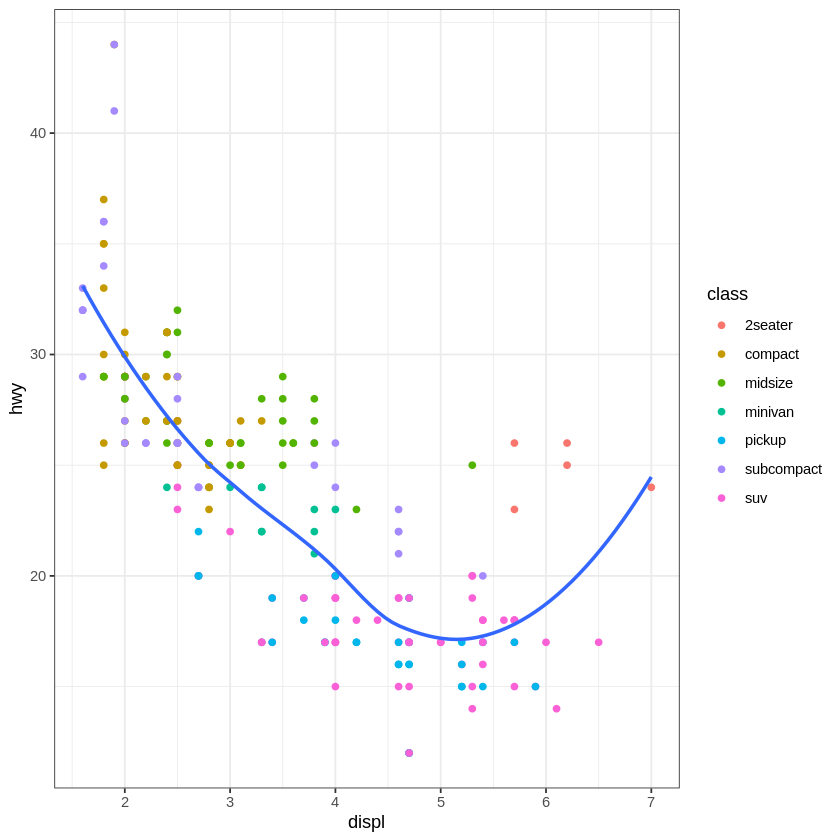

In [26]:
ggplot(mpg, aes(displ, hwy)) +
  geom_point(aes(color = class)) +
  geom_smooth(se = FALSE) +
  theme_bw()


ggplot2 includes eight themes by default, as shown in @fig-themes.
Many more are included in add-on packages like **ggthemes** (<https://github.com/jrnold/ggthemes>), by Jeffrey Arnold.




<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/6be25cfb939e69d72df9fbc68e7a0334e1febefe/10e92/images/visualization-themes.png" alt="img R" >
    The eight themes built-in to ggplot2.
</center>



Many people wonder why the default theme has a grey background.
This was a deliberate choice because it puts the data forward while still making the grid lines visible.
The white grid lines are visible (which is important because they significantly aid position judgements), but they have little visual impact and we can easily tune them out.
The grey background gives the plot a similar typographic colour to the text, ensuring that the graphics fit in with the flow of a document without jumping out with a bright white background.
Finally, the grey background creates a continuous field of colour which ensures that the plot is perceived as a single visual entity.

It's also possible to control individual components of each theme, like the size and colour of the font used for the y axis.
Unfortunately, this level of detail is outside the scope of this book, so you'll need to read the [ggplot2 book](https://ggplot2-book.org/) for the full details.
You can also create your own themes, if you are trying to match a particular corporate or journal style.

## Saving your plots

There are two main ways to get your plots out of R and into your final write-up: `ggsave()` and knitr.
`ggsave()` will save the most recent plot to disk:



Saving 6.67 x 6.67 in image



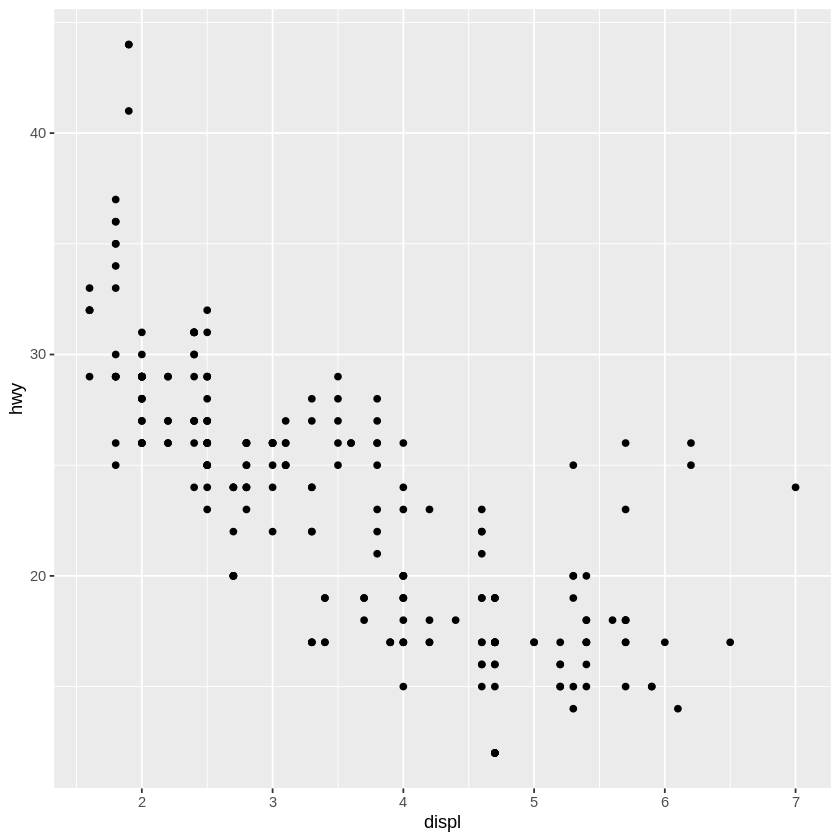

In [27]:
ggplot(mpg, aes(displ, hwy)) + geom_point()
ggsave("my-plot.pdf")


```{r}
#| fig-show: "hide"

ggplot(mpg, aes(displ, hwy)) + geom_point()
ggsave("my-plot.pdf")
```




If you don't specify the `width` and `height` they will be taken from the dimensions of the current plotting device.
For reproducible code, you'll want to specify them.

Generally, however, I think you should be assembling your final reports using R Markdown, so I want to focus on the important code chunk options that you should know about for graphics.
You can learn more about `ggsave()` in the documentation.

### Figure sizing

<!--# TO DO: Add something about faceted plots here. -->

The biggest challenge of graphics in R Markdown is getting your figures the right size and shape.
There are five main options that control figure sizing: `fig.width`, `fig.height`, `fig.asp`, `out.width` and `out.height`.
Image sizing is challenging because there are two sizes (the size of the figure created by R and the size at which it is inserted in the output document), and multiple ways of specifying the size (i.e., height, width, and aspect ratio: pick two of three).

I only ever use three of the five options:

-   I find it most aesthetically pleasing for plots to have a consistent width.
    To enforce this, I set `fig.width = 6` (6") and `fig.asp = 0.618` (the golden ratio) in the defaults.
    Then in individual chunks, I only adjust `fig.asp`.

-   I control the output size with `out.width` and set it to a percentage of the line width.
    I default to `out.width = "70%"` and `fig.align = "center"`.
    That gives plots room to breathe, without taking up too much space.

-   To put multiple plots in a single row I set the `out.width` to `50%` for two plots, `33%` for 3 plots, or `25%` to 4 plots, and set `fig.align = "default"`.
    Depending on what I'm trying to illustrate (e.g. show data or show plot variations), I'll also tweak `fig.width`, as discussed below.

If you find that you're having to squint to read the text in your plot, you need to tweak `fig.width`.
If `fig.width` is larger than the size the figure is rendered in the final doc, the text will be too small; if `fig.width` is smaller, the text will be too big.
You'll often need to do a little experimentation to figure out the right ratio between the `fig.width` and the eventual width in your document.
To illustrate the principle, the following three plots have `fig.width` of 4, 6, and 8 respectively:



<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/31b35123aa5fe3e73417db4f025913ab82c11b63/eca08/communicate-plots_files/figure-html/unnamed-chunk-34-1.png" alt="img R" width="450" height="300" >
</center>

<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/37a1e740edb08c94fb9c7d67d63dd30a3303b0c3/0841d/communicate-plots_files/figure-html/unnamed-chunk-35-1.png" alt="img R" width="450" height="300" >
</center>

<center>
    <img src="https://d33wubrfki0l68.cloudfront.net/32c893c4a8b108dfb0a3b220953c93f0de535be0/c6a92/communicate-plots_files/figure-html/unnamed-chunk-36-1.png" alt="img R" width="450" height="300" >
</center>


If you want to make sure the font size is consistent across all your figures, whenever you set `out.width`, you'll also need to adjust `fig.width` to maintain the same ratio with your default `out.width`.
For example, if your default `fig.width` is 6 and `out.width` is 0.7, when you set `out.width = "50%"` you'll need to set `fig.width` to 4.3 (6 \* 0.5 / 0.7).

### Other important options

When mingling code and text, like I do in this book, I recommend setting `fig.show = "hold"` so that plots are shown after the code.
This has the pleasant side effect of forcing you to break up large blocks of code with their explanations.

To add a caption to the plot, use `fig.cap`.
In R Markdown this will change the figure from inline to "floating".

If you're producing PDF output, the default graphics type is PDF.
This is a good default because PDFs are high quality vector graphics.
However, they can produce very large and slow plots if you are displaying thousands of points.
In that case, set `dev = "png"` to force the use of PNGs.
They are slightly lower quality, but will be much more compact.

It's a good idea to name code chunks that produce figures, even if you don't routinely label other chunks.
The chunk label is used to generate the file name of the graphic on disk, so naming your chunks makes it much easier to pick out plots and reuse in other circumstances (i.e. if you want to quickly drop a single plot into an email or a tweet).

## Learning more

The absolute best place to learn more is the ggplot2 book: [*ggplot2: Elegant graphics for data analysis*](https://ggplot2-book.org/).
It goes into much more depth about the underlying theory, and has many more examples of how to combine the individual pieces to solve practical problems.

Another great resource is the ggplot2 extensions gallery <https://exts.ggplot2.tidyverse.org/gallery/>.
This site lists many of the packages that extend ggplot2 with new geoms and scales.
It's a great place to start if you're trying to do something that seems hard with ggplot2.
